### FRAUD DETECTION IN FINANCIAL TRANSACTIONS USING MACHINE LEARNING ON GOOGLE CLOUD

# Important Variables

* Trasaction Type: Is most important variable, Fruad is mostly found in TRANSFER and CASH_OUT transaction.Other types like PAYMENT or DEBIT rarely have fraud.
* Transaction Amount:  Fraudulent transactions often have higher amounts.
* Account Balance Changes:  Fraudulent transactions often show suspicios balace changes.  
                            Eg. A fraudulster may transfer money out, leaving their balance unchanged.

In [41]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2 google-cloud-aiplatform

  Using cached google_auth_oauthlib-1.2.1-py2.py3-none-any.whl (24 kB)
  Using cached google_auth_httplib2-0.2.0-py2.py3-none-any.whl (9.3 kB)
                                              0.0/96.9 kB ? eta -:--:--
     ----------------                         41.0/96.9 kB ? eta -:--:--
     ----------------                         41.0/96.9 kB ? eta -:--:--
     ----------------                         41.0/96.9 kB ? eta -:--:--
     ----------------                         41.0/96.9 kB ? eta -:--:--
     ----------------                         41.0/96.9 kB ? eta -:--:--
     --------------------------------       81.9/96.9 kB 254.2 kB/s eta 0:00:01
     -------------------------------------- 96.9/96.9 kB 276.7 kB/s eta 0:00:00
                                              0.0/151.7 kB ? eta -:--:--
     ------------------                      71.7/151.7 kB 2.0 MB/s eta 0:00:01
     ----------------------------           112.6/151.7 kB 2.2 MB/s eta 0:00:01
     ----------------------

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler
from sklearn.feature_extraction import FeatureHasher
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [4]:
df = pd.read_csv("Synthetic_Financial_datasets_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Dataset Overview

In [3]:
df.shape

(6362620, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

* There is no null value present in the dataset

In [6]:
# Check for Duplicate Rows
print(f"No of Duplicate Rows: {df.duplicated().sum()}")

No of Duplicate Rows: 0


In [7]:
# Descriptive Statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


# Exploratory Data Analysis

In [8]:
# Display settings
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style="whitegrid")

# Plotting settings
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

## Q.What types of transactions appear in the datasets and what are their frequencies?

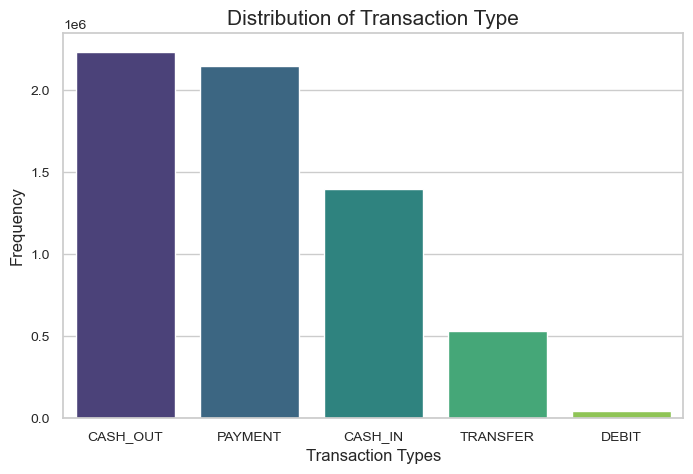

In [9]:
# Count the occurences of each transaction types
transaction_counts = df["type"].value_counts()

# Plot the distibution of transaction types
sns.barplot(x=transaction_counts.index, y = transaction_counts.values, palette="viridis")
plt.title("Distribution of Transaction Type")
plt.xlabel("Transaction Types")
plt.ylabel("Frequency")
plt.show()

### Insights

* The most common transaction types are 'CASH_OUT' and 'PAYMENT', while 'TRANSFER' and 'DEBIT' are less frequent.  

* This pattern might suggest that frauds are likely to occure in specific transaction type (such as 'CASH_OUT' or 'PAYMENT'), as this offer ways to withdraw and or funds.

In [10]:
df["type"].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

## Q.Which transaction type has highest fraud percentage?

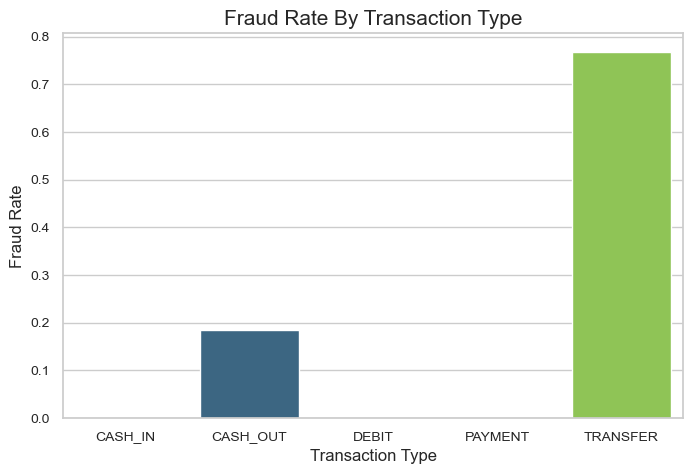

In [11]:
# Calculate the fraud rate for each transaction type
fraud_by_type = df.groupby('type')['isFraud'].mean() * 100

# Plot the fraud rate by the transaction type
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values,palette='viridis')
plt.title("Fraud Rate By Transaction Type")
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate')
plt.show()

### Insights
* It appears that the fraud rate of all transaction types are extremely low, with the highest fraud rate being 1% for TRANSFER. This suggest that fraud is relatively rare across all transaction type, but transfer might be slightly more subsceptible to fraudulent activity compared to others.

* Given the very low fraud rates, This indicates the highly imbalenced dataset, which is typically in fraud detection problem. This will required techniques like oversampling or anamoly detection during model training to properly identify fraudulent transactions.

## Q.What is the distribution of amounts in fraudulent vs non-fraudulent transactions?

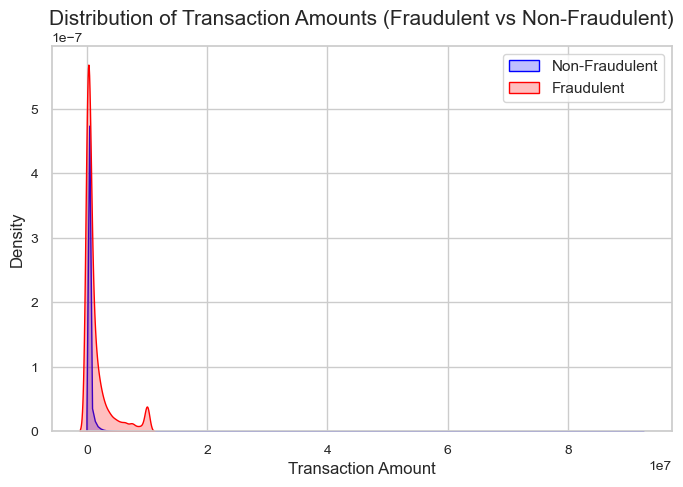

In [12]:
# Plot the distribution of transaction amount for fraudulent vs non-fraudulent transactions
sns.kdeplot(df[df['isFraud'] == 0]['amount'], label="Non-Fraudulent", fill=True, color="blue")
sns.kdeplot(df[df['isFraud'] == 1]['amount'], label="Fraudulent", fill=True, color="red")
plt.title("Distribution of Transaction Amounts (Fraudulent vs Non-Fraudulent)")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.legend()
plt.show()

### Insights
* Fraudulent have the significantly higher amount compared to non-fraudulent ones  
  * Non-Fraudulent Transaction- The distribution is highly skewed due to preference of some extremely large transactions.  
  * Fraudulent Transactions - The values of fraudulent transactions are higher. This indicates that fraudsters tends to focus on much larger transactions.
 

## Q.Are there any balance characteristics associated with fraud?

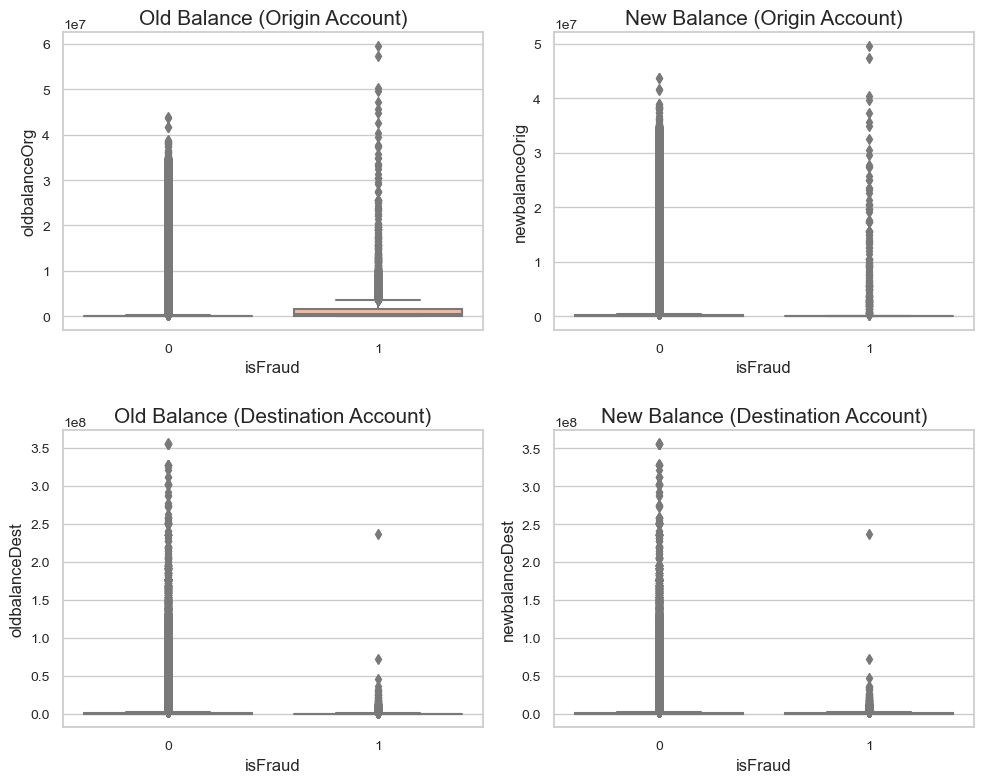

In [13]:
# Create boxplot to compare balances (old vs new) for fraudulent vs non-fraudulent transaction
plt.figure(figsize=(10,8))

# Old balance for the origin account
plt.subplot(2,2,1)
sns.boxplot(x='isFraud', y='oldbalanceOrg', data=df, palette='coolwarm')
plt.title("Old Balance (Origin Account)")

plt.subplot(2,2,2)
sns.boxplot(x='isFraud', y='newbalanceOrig', data=df, palette='coolwarm')
plt.title('New Balance (Origin Account)')

plt.subplot(2,2,3)
sns.boxplot(x='isFraud', y='oldbalanceDest', data=df, palette='coolwarm')
plt.title('Old Balance (Destination Account)')

plt.subplot(2,2,4)
sns.boxplot(x='isFraud', y='newbalanceDest', data=df, palette='coolwarm')
plt.title('New Balance (Destination Account)')

plt.tight_layout()
plt.show()

### Insights
* Old balance of origin account  
    * Fraudulent transactions (isFraud = 1) tent to have high starting balances.  
    * Non- fraudulent transactions (isFraud = 0) show a wider spread, including low balance.
* New balance of origin account  
    * After fraudulent transactions, the remaining balance in the origin accounts is significantly reduced.  
    * This suggest that fraudsters often drain the account or transfer a large portion of the funds.  
* Old balance of destination account  
     * Fraudlent transaction often involve destination acciunts that already have high balances.  
     * Non-fraudulent transaction involves wider range of balance.  
* New balance of destination account  
     * A key fraud pattern is sudden large increase in the balance of the destination account.  
     * This suggest that fraudulent transaction result in big deposits to certain accounts.  

* Changes in balances  
  * Fraudulent transaction shows more drastic changes in balances, particularly in the destination account, where there are 
    more significant increase in the 'new balance'. 

* These insight suggest that fraudulent transactions are often associated with larger account balance and more significant balance changes, which can be key feauters to focus on during fraud detection modeling.

# Q.How are fraudulent transactions distributed over time (steps)?

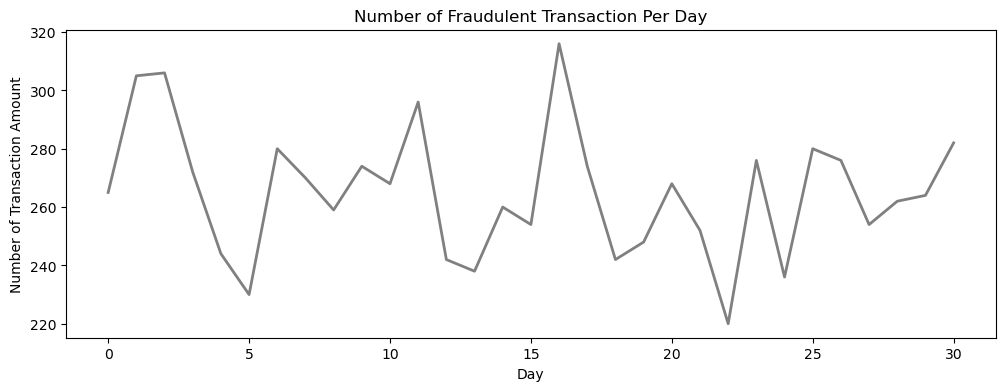

In [5]:
# Create the new column representing the day (each 24-hour period in the step count)
df["day"] = df["step"] // 24

# Group fraudulent transaction by day
fraud_per_day = df[df["isFraud"] ==1].groupby("day").size()

# Plot the fraudulent transaction per day
plt.figure(figsize= (12,4))
fraud_per_day.plot(kind= 'line', color = 'grey', linewidth = 2)
plt.title("Number of Fraudulent Transaction Per Day")
plt.xlabel("Day")
plt.ylabel("Number of Transaction Amount")
plt.show()

### Insights
* Consistent Fraud Levels: Fraudulent transaction counts reamins stable across days, including steady fraud activity without significant daily fluctuations.  

* Uniform Fraud Distribution: The absence of extreme peacks or drops suggest that fraudulent activity is evenly distributed, possibly reflicting realistic, continuous fraud attempts rather than event-based spike.

### Fraud vs Non Fraud

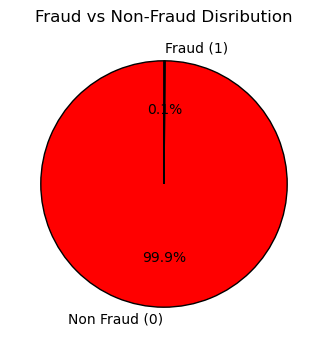

In [9]:

fraud_counts = df["isFraud"].value_counts()

labels = ["Non Fraud (0)","Fraud (1)"]

colors = ["red","lightblue"]

plt.figure(figsize=(4,4))
plt.pie(fraud_counts, labels=labels, autopct="%1.1f%%", colors = colors,startangle=90,wedgeprops={"edgecolor":"black"})

plt.title("Fraud vs Non-Fraud Disribution")

plt.show()

In [10]:
fraud_counts

0    6354407
1       8213
Name: isFraud, dtype: int64

# Correlation

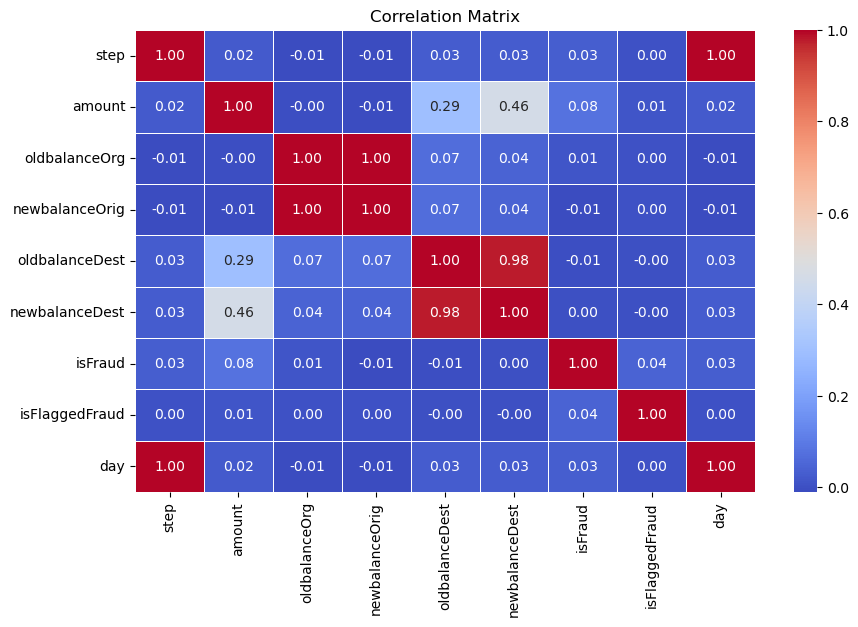

In [4]:
# Select only numerical columns for correlation calculations.
numerical_col = df.select_dtypes(include=['float64','int64']).columns

# Compute the correlation matrix only for numerical column
correlation_matrix = df[numerical_col].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [12]:
correlation_matrix

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277,0.999539
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295,0.023307
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835,-0.010042
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776,-0.010288
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513,0.027752
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529,0.026128
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109,0.032577
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000,0.003296
day,0.999539,0.023307,-0.010042,-0.010288,0.027752,0.026128,0.032577,0.003296,1.000000


In [6]:
# Feature Engineering

In [7]:
# Creating new feature: balance difference for origin (oldbalanceOrg - newbalanceOrig)
df['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']

# Creating new feature: balance difference for destination (oldbalanceDest - newbalanceDest)
df['balance_diff_dest'] = df['oldbalanceDest'] - df['newbalanceDest']
# Creating new feature: rate of balance change for origin
df['balance_change_rate_orig'] = (df['oldbalanceOrg'] - df['newbalanceOrig']) / df['oldbalanceOrg']

# Creating new feature: rate of balance change for destination
df['balance_change_rate_dest'] = (df['oldbalanceDest'] - df['newbalanceDest']) / df['oldbalanceDest']

In [8]:
# Counting the number of transactions for each customer (nameOrig and nameDest)
df['trans_count_orig'] = df.groupby('nameOrig')['step'].transform('count')
df['trans_count_dest'] = df.groupby('nameDest')['step'].transform('count')

In [9]:
# Preprocessing

In [10]:
# One-Hot Encode only 'type', which has limited categories
df = pd.get_dummies(df, columns=['type'], drop_first=True)
# Label Encoding for high-cardinality 'nameOrig' and 'nameDest'
le_nameOrig = LabelEncoder()
le_nameDest = LabelEncoder()
df['nameOrig_encoded'] = le_nameOrig.fit_transform(df['nameOrig'])
df['nameDest_encoded'] = le_nameDest.fit_transform(df['nameDest'])
# Drop the original columns to save memory
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs in rate features with 0 as a neutral balance change
df['balance_change_rate_orig'].fillna(0, inplace=True)
df['balance_change_rate_dest'].fillna(0, inplace=True)

# List of numerical features to scale
numerical_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
                      'newbalanceDest', 'balance_diff_orig', 'balance_diff_dest', 
                      'balance_change_rate_orig', 'balance_change_rate_dest']

# Scale numerical features to ensure standardized values
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

print("Preprocessing complete, scaling applied successfully.")

Preprocessing complete, scaling applied successfully.


In [12]:
# Step 4: Data balancing using SMOTE for the target variable 'isFraud'
X = df.drop(columns=['isFraud'])
y = df['isFraud']

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [13]:
# Combine balanced X and y into a single DataFrame
df_balanced = pd.concat([X_balanced, y_balanced], axis=1)

In [14]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [15]:
# Check the shape of each split
print("Training set (features):", X_train.shape)
print("Training set (target):", y_train.shape)
print("Test set (features):", X_test.shape)
print("Test set (target):", y_test.shape)

# Confirm target distribution in training and test sets
print("Training set fraud cases:", y_train.sum())
print("Test set fraud cases:", y_test.sum())

Training set (features): (10167051, 20)
Training set (target): (10167051,)
Test set (features): (2541763, 20)
Test set (target): (2541763,)
Training set fraud cases: 5083481
Test set fraud cases: 1270926


In [16]:
# Check the distribution of the target (fraud vs. non-fraud)
print("Training set fraud distribution:")
print(y_train.value_counts())

print("Test set fraud distribution:")
print(y_test.value_counts())

Training set fraud distribution:
0    5083570
1    5083481
Name: isFraud, dtype: int64
Test set fraud distribution:
1    1270926
0    1270837
Name: isFraud, dtype: int64


In [17]:
# Combine X_train and y_train into a single DataFrame for sub-sampling
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Sub-sample 10% of the training data while maintaining class proportions
train_sample = train_data.groupby('isFraud', group_keys=False).apply(
    lambda x: x.sample(frac=0.1, random_state=42)
)

# Sub-sample 10% of the test data while maintaining class proportions
test_sample = test_data.groupby('isFraud', group_keys=False).apply(
    lambda x: x.sample(frac=0.1, random_state=42)
)

# Split the sampled data back into features and target
X_train_sample = train_sample.drop(columns='isFraud')
y_train_sample = train_sample['isFraud']

X_test_sample = test_sample.drop(columns='isFraud')
y_test_sample = test_sample['isFraud']

# Check new class distributions
print("Training sample fraud distribution:")
print(y_train_sample.value_counts())

print("Testing sample fraud distribution:")
print(y_test_sample.value_counts())

Training sample fraud distribution:
0    508357
1    508348
Name: isFraud, dtype: int64
Testing sample fraud distribution:
1    127093
0    127084
Name: isFraud, dtype: int64


In [18]:
# Import 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

In [19]:
# Initialize the MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(50,),     
    max_iter=50,              
    random_state=42,               
    solver='adam',          
    learning_rate='adaptive'  
)

# Train the model using the sampled training data 
print("Training MLP on Training Set...")
mlp_model.fit(X_train_sample, y_train_sample)

Training MLP on Training Set...


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(50,), learning_rate='adaptive', max_iter=50,
              random_state=42)

In [20]:
# Make predictions on the sampled test set
y_test_pred_mlp = mlp_model.predict(X_test_sample)
y_test_pred_proba_mlp = mlp_model.predict_proba(X_test_sample)[:, 1]  

# Evaluate on the sampled test set
test_accuracy_mlp = accuracy_score(y_test_sample, y_test_pred_mlp)
test_roc_auc_mlp = roc_auc_score(y_test_sample, y_test_pred_proba_mlp)

# Calculate F1-Score for the test set
test_f1_score_mlp = classification_report(y_test_sample, y_test_pred_mlp, output_dict=True)['accuracy']

# Print results for the test set
print(f"\nMLP Test Accuracy: {test_accuracy_mlp:.4f}")
print(f"MLP Test ROC-AUC: {test_roc_auc_mlp:.4f}")
print(f"MLP Test F1-Score: {test_f1_score_mlp:.4f}")

# Save the results
test_results_mlp = {
    'Model': 'MLP',
    'Test Accuracy': test_accuracy_mlp,
    'Test ROC-AUC': test_roc_auc_mlp,
    'Test F1-Score': test_f1_score_mlp
    }

# Convert the results dictionary into a DataFrame
test_results_mlp_df = pd.DataFrame([test_results_mlp])


MLP Test Accuracy: 0.9180
MLP Test ROC-AUC: 0.9652
MLP Test F1-Score: 0.9180


In [21]:
print("\nMLP Classification Report:")
print(classification_report(y_test_sample, y_test_pred_mlp))

print("\nMLP Confusion Matrix:")
print(confusion_matrix(y_test_sample, y_test_pred_mlp))


MLP Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92    127084
           1       0.96      0.87      0.91    127093

    accuracy                           0.92    254177
   macro avg       0.92      0.92      0.92    254177
weighted avg       0.92      0.92      0.92    254177


MLP Confusion Matrix:
[[122135   4949]
 [ 15904 111189]]


In [22]:
# Import
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

In [23]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,  
    scale_pos_weight=1,  
    use_label_encoder=False, 
    eval_metric='logloss'  
)

# Train the model using the sampled training data
print("Training XGBoost on Training Set...")
xgb_model.fit(X_train_sample, y_train_sample)

Training XGBoost on Training Set...


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [24]:
# Make predictions on the sampled test set
y_test_pred_xgb = xgb_model.predict(X_test_sample)
y_test_pred_proba_xgb = xgb_model.predict_proba(X_test_sample)[:, 1]  

# Evaluate on the sampled test set
test_accuracy_xgb = accuracy_score(y_test_sample, y_test_pred_xgb)
test_roc_auc_xgb = roc_auc_score(y_test_sample, y_test_pred_proba_xgb)

# Calculate F1-Score for the test set
test_f1_score_xgb = classification_report(y_test_sample, y_test_pred_xgb, output_dict=True)['accuracy']

# Print results for the test set
print(f"\nXGBoost Test Accuracy: {test_accuracy_xgb:.4f}")
print(f"XGBoost Test ROC-AUC: {test_roc_auc_xgb:.4f}")
print(f"XGBoost Test F1-Score: {test_f1_score_xgb:.4f}")

# Save the results
test_results_xgb = {
    'Model': 'XGBoost',
    'Test Accuracy': test_accuracy_xgb,
    'Test ROC-AUC': test_roc_auc_xgb,
    'Test F1-Score': test_f1_score_xgb
}

# Convert the results dictionary into a DataFrame
test_results_xgb_df = pd.DataFrame([test_results_xgb])


XGBoost Test Accuracy: 0.9993
XGBoost Test ROC-AUC: 1.0000
XGBoost Test F1-Score: 0.9993


In [25]:
print("\nXGBoost Classification Report:")
print(classification_report(y_test_sample, y_test_pred_xgb))

print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test_sample, y_test_pred_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127084
           1       1.00      1.00      1.00    127093

    accuracy                           1.00    254177
   macro avg       1.00      1.00      1.00    254177
weighted avg       1.00      1.00      1.00    254177


XGBoost Confusion Matrix:
[[126922    162]
 [    15 127078]]
